# Imports

In [364]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import gridspec
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, normalize, minmax_scale
from sklearn.decomposition import PCA
from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm
from scipy import stats
import loc_utils as lut
import PIL

plt.style.use('my.mplstyle')

# Some python voodoo to make make relative imports work
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from modeling.loc_utils import ewmv
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Learning and choices

No handles with labels found to put in legend.


Saving figure as ../figures/task_and_behavior.png


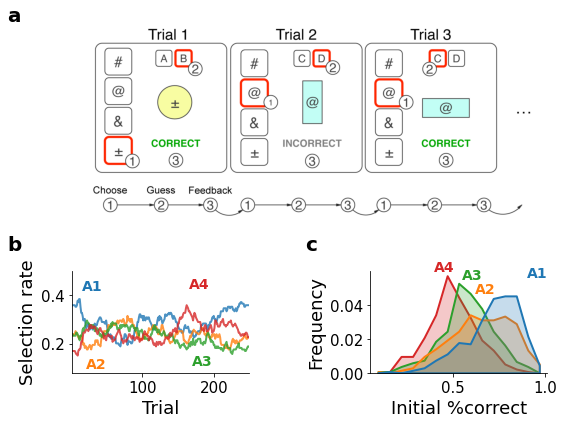

In [1000]:
def task_description(ax, data_path):
    img = PIL.Image.open(data_path)
    img.load(scale=10)
    ax.imshow(img)
    
    
def task_choices(ax, data_path):
    # Load data, select columns
    df = pd.read_csv(data_path)[['sid','group','trial','activity']]
    # Select free-play trials
    df = df.loc[df.trial.le(60+250) & df.trial.gt(60) & df.group.eq(0), :]
    df.loc[:, 'trial'] -= 60
    # Get group sizes
    group_size = df.sid.unique().size
    # Count subjects per activity per trial for each group
    df = df.groupby(['activity','trial']).agg({'sid': 'nunique'})
    df = df.rename(columns={'sid':'n'})
    # Plot data
    for j, activity in enumerate('A1,A2,A3,A4'.split(',')):
        psel = df.loc[(activity, slice(None)), 'n'].values / group_size
        ax.plot(psel, lw=2, alpha=.8)
    # Labels
    ax.set_xlim(1, 250)
    ax.set_ylim(.08, .5)
    ax.set_xlabel('Trial')
    ax.set_ylabel('Selection rate')
    # Add legend
    cmap = sns.color_palette('tab10', as_cmap=True)
    ax.text(15, .42, 'A1', color=cmap(0), fontweight='bold', fontsize=14)
    ax.text(20, .1, 'A2', color=cmap(1), fontweight='bold', fontsize=14)
    ax.text(170, .11, 'A3', color=cmap(2), fontweight='bold', fontsize=14)
    ax.text(165, .43, 'A4', color=cmap(3), fontweight='bold', fontsize=14)


def learning(ax, data_path):
    # Load data
    df = pd.read_csv(data_path)
    # Plot data
    sns.histplot(
        df, x='ipc15', hue='activity', element='poly',
        stat='probability', common_norm=True, bins=15, ax=ax,
        palette='tab10', legend=True,
        linewidth=2
    )
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Initial %correct')
    # Add legend
    cmap = sns.color_palette('tab10', as_cmap=True)
    ax.legend().remove()
    ax.text(.9, .056, 'A1', color=cmap(0), fontweight='bold', fontsize=14)
    ax.text(.62, .047, 'A2', color=cmap(1), fontweight='bold', fontsize=14)
    ax.text(.55, .055, 'A3', color=cmap(2), fontweight='bold', fontsize=14)
    ax.text(.4, .06, 'A4', color=cmap(3), fontweight='bold', fontsize=14)


def make_fig1(figname, save_path=''):
    fig = plt.figure(figname, figsize=[8, 6], facecolor='w')
    gs = fig.add_gridspec(ncols=4, nrows=2, 
                          width_ratios=[.05, 1, .05, 1],
                          height_ratios=[1, .5])
    
    # Subplot (a)
    lut.add_subplot_label(x=0, y=1, label='a', size=20, ax=fig.add_subplot(gs[0, 0]))
    img_ax = fig.add_subplot(gs[0, 1:])
    lut.ghost(img_ax)
    img_ax.tick_params(labelbottom=False)
    task_description(img_ax, '../figures/task_structure.eps')
   
    # Subplot (c)
    lut.add_subplot_label(x=0, y=1.2, label='b', size=20, ax=fig.add_subplot(gs[1, 0]))
    ax = fig.add_subplot(gs[1, 1])
    task_choices(ax, '../data/clean_data.csv')
   
    # Subplot (c)
    lut.add_subplot_label(x=0, y=1.2, label='c', size=20, ax=fig.add_subplot(gs[1, 2]))
    ax = fig.add_subplot(gs[1, 3])
    learning(ax, '../data/behavior_data.csv')
    

    # Save figure
    fig.tight_layout()
    fig.subplots_adjust(wspace=.6)
    if save_path:
        print(f'Saving figure as {save_path}')
        fig.savefig(fname=save_path, dpi=300)
        
    
def learning_anova(data_path):
    df = pd.read_csv(data_path)
    lm = ols('ipc15 ~ C(activity)', data=df).fit()
    display(sm.stats.anova_lm(lm, typ=2))
    display(
        sm.stats.multicomp.pairwise_tukeyhsd(
            endog = df.ipc15,
            groups = df.activity,
            alpha = .01
        ).summary()
    )

        
make_fig1(
    figname = 'figure1',
    save_path = '../figures/task_and_behavior.png'
)

# learning_anova('../data/behavior_data.csv')

# AIC-based analyses

## Comparisons

Sample size = 159


sid         form       aic          tau      step     scale      comp  \
0    0  V + ∆M + ∆V  200.9594   400.748590  0.983901  0.013794       NaN   
1    0   M + V + ∆V  437.3286  1000.000000  0.860970  0.003762 -0.001691   
2    0       M + ∆M  486.8968   927.729437  0.877321  0.001855 -0.001969   
3    0  M + ∆M + ∆V  490.2942   759.460109  0.985216  0.009855  0.000655   
4    0   M + V + ∆M  494.9430   456.377048  0.962275  0.000383 -0.003974   

        unc     dcomp      dunc  group  k        aicc  delta_aicc  \
0  1.000000  0.160092 -0.998801      0  7  201.422210    0.000000   
1 -0.938066       NaN -1.000000      0  7  437.791410  236.369200   
2       NaN -0.097522       NaN      0  6  487.242479  285.820269   
3       NaN  0.111273 -0.897958      0  7  490.757010  289.334800   
4  0.852254 -0.840987       NaN      0  7  495.405810  293.983600   

            akw            er  drank  
0  1.000000e+00  1.000000e+00      0  
1  4.710645e-52  2.122852e+51      1  
2  8.608295e-63  1.161670e+62      2  
3  1.485068e-63  6.733696e+62      3  
4  1.453023e-64  6.882205e+63      4

Saving figure as ../figures/comparisons.png


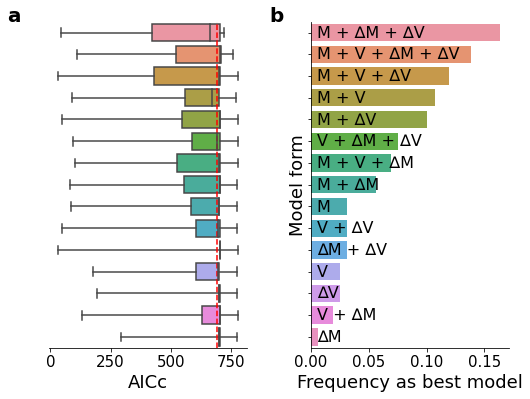

In [529]:
def akaike_weights(data_path, figname, save_path=''):
    df = pd.read_csv(data_path).reset_index()
    df = lut.rename_components(df)
    varlist = list(df.loc[:, 'M':'group'].columns)[:-1]
    keylist = [f'z__{v}' for v in varlist]
    out = dict(zip(['sid']+keylist,[[] for i in range(len(varlist)+2)]))
    for i, sdf in df.groupby('sid'):
        out['sid'].append(i)
        for k, v in zip(keylist, varlist):
            out[k].append(np.sum(sdf.loc[~sdf.loc[:, v].isna(), 'akw']))

    df = pd.DataFrame(out)
    long = pd.wide_to_long(df, 'z', 'sid', 'ucomp', sep='__', suffix='\D+').reset_index()

    stats = df.agg(['mean', 'std'])
    display(stats.transpose())
    
    df = pd.wide_to_long(df, 'z', 'sid', 'ucomp', sep='__', suffix='\D+').reset_index()
    df = df.rename(columns={'z': 'weight'})

    fig, ax = plt.subplots(ncols=1, figsize=[5, 4])
    sns.barplot(x='ucomp', y='weight', data=df, ax=ax, ci=95, order=['M', '∆M', 'V', '∆V'])
    ax.set_xlabel('Utility component')
    ax.set_ylabel('Akaike weight')
    fig.tight_layout()
    if save_path:
        print(f'Saving figure to {save_path}')
        fig.savefig(save_path, dpi=300)
    
    
    lm = ols('z ~ C(ucomp)', data=long).fit()
    display(sm.stats.anova_lm(lm, typ=2))
    display(
        sm.stats.multicomp.pairwise_tukeyhsd(
            endog = long.z,
            groups = long.ucomp,
            alpha = .01
        ).summary()
    )


def best_per_subject(ax, data_path):
    # Load dataset
    df = pd.read_csv(data_path)
    df = lut.rename_components(df)
    
    # Conver AIC to AICc
    df['k'] = 9 - df.loc[:, 'tau':].isnull().sum(axis=1)
    df['aicc'] = df.aic + (2*df.k**2 + 2*df.k)/(250-df.k-1)
    
    best_models = df.sort_values(by=['sid', 'aicc']).groupby(['sid']).head(1)
    best_models = best_models.filter(items=['sid','group','form'])
    best_models = best_models.groupby(['group','form']).count().rename(columns={'sid':'freq'})
    best_models = best_models.groupby('group').transform(lambda x: x / sum(x))
    best_models.reset_index(inplace=True)
    
    plot_df = best_models.sort_values('freq', ascending=False)
    sns.barplot(y='form', x='freq', data=plot_df, ax=ax, orient='h')
    ax.tick_params(labelleft=False)
    ax.set_ylabel('Model form')
    ax.set_xlabel('Frequency as best model')
    print(f'Sample size = {len(df.sid.unique())}')
    for i, comb in enumerate(list(plot_df.form)):
        ax.text(0.005, i, comb, va='center', fontsize=16)
    return plot_df.form
        
        
def delta_aic_per_form(ax, data_path):
    # Load dataset
    df = pd.read_csv(data_path)
    df = lut.rename_components(df)
    delta_rand = -2*np.sum(np.log(.25)*250) - df.loc[df.drank.eq(0), 'aicc']
    df = df.groupby('form')[['delta_aicc']].agg(['median', 'sem'])
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df.loc['unform choice'] = [delta_rand.median(), delta_rand.sem()]
    display(df.head())
    
    df = df.sort_values('delta_aicc_median', ascending=True)
    df = df.reset_index()
    sns.barplot(y='form', x='delta_aicc_median',  data=df, ax=ax, orient='h')
    ax.tick_params(labelleft=False)
    ax.set_ylabel('Model form')
    ax.set_xlabel(r'$\Delta \mathrm{AIC} $')
    for i, comb in enumerate(list(df.form)):
        ax.text(10, i, comb, va='center', fontsize=16)
        

def aic_per_form(ax, data_path, order):
    # Load dataset
    df = pd.read_csv(data_path)
    df = lut.rename_components(df)
    df = df.loc[df.aicc < 10000, :]
    rand =  -2*np.sum(np.log(.25)*250)
    display(df.head())
    df = df.reset_index()
    sns.boxplot(y='form', x='aicc', order=order, data=df, ax=ax, orient='h', whis=[0,100])
    ax.tick_params(labelleft=False)
    ax.set_ylabel('')
    ax.set_xlabel('AICc')
    ax.axvline(rand, color='red', ls='--')
    ax.get_yaxis().set_visible(False)
    ax.get_yaxis().set_ticks([])
    ax.spines['left'].set_visible(False)

    

def model_comparisons_fig(figname, save_path=''):
    fig = plt.figure(num=figname, figsize=[9, 6])
    gs = fig.add_gridspec(ncols=4, nrows=1, width_ratios=[.1, 1, .1, 1])
    
    ax = lut.add_subplot_label(x=0, y=1, label='a', size=20, ax=fig.add_subplot(gs[0, 0]))
    o = best_per_subject(ax=fig.add_subplot(gs[0, 3]), data_path='../data/best_per_form_app4.csv')
    
    ax = lut.add_subplot_label(x=0, y=1, label='b', size=20, ax=fig.add_subplot(gs[0, 2]))
    aic_per_form(ax=fig.add_subplot(gs[0, 1]), data_path='../data/aic_stats_app4.csv', order=o)

    if save_path:
        print(f'Saving figure as {save_path}')
        fig.savefig(fname=save_path, dpi=300)

    
model_comparisons_fig(
    figname = 'fig1',
    save_path = '../figures/comparisons.png'
)


# akaike_weights(
#     data_path = '../data/aic_stats_app4.csv', 
#     figname = 'akaike_weights', 
# #     save_path = '../figures/akaike_weights.png'
# )

## Qualitative fit

sid activity  alloc
0    0       A1  0.000
1    0       A2  0.064
2    0       A3  0.712
3    0       A4  0.224
4    1       A1  0.296

sid activity  alloc
0  146       A1  0.100
1  146       A2  0.276
2  146       A3  0.452
3  146       A4  0.172
4    6       A1  0.084

sid activity  alloc
0   26       A1  0.284
1   26       A2  0.300
2   26       A3  0.068
3   26       A4  0.348
4   27       A1  0.232

Saving figure as ../figures/qual_fit1000b.png


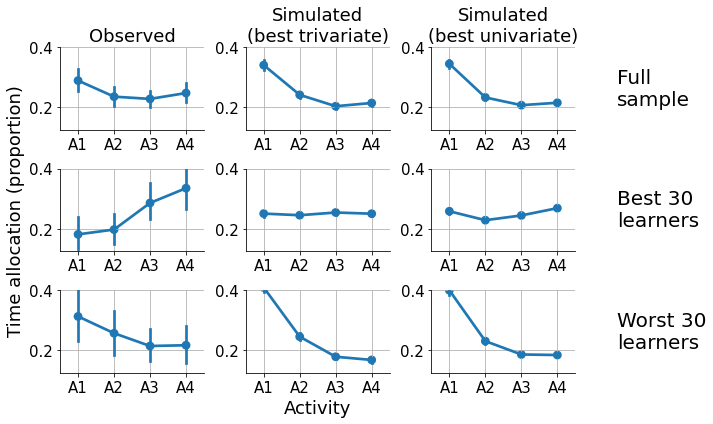

In [943]:
def softmax(x, tau):
    z = x - x.max()
    e = np.exp(z*tau)
    return e / e.sum()


def sim_choices(fp, x):
    betas = fp['comp':'dunc']
    betas = betas[betas.notna()]    # May be convert to numpy
    comps = list(betas.index)
    betas = betas.to_numpy()
    
    sim_features = [[] for i in [1,2,3,4]]    # One empty list per task
    for i, v in enumerate(x.T):
        fast = ewmv(v, fp.step, init_mean=.5, init_var=.25, return_keys=['mean', 'var'])
        if 'comp' in comps:
            sim_features[i].append(fast['mean'])
        if 'unc' in comps:
            sim_features[i].append(fast['var'])
        if fp.scale != np.nan:
            slow = ewmv(v, fp.step*fp.scale, init_mean=.5, init_var=.25, return_keys=['mean', 'var'])
            if 'dcomp' in comps:
                sim_features[i].append(np.abs(fast['mean'] - slow['mean']))
            if 'dunc' in comps:
                sim_features[i].append(np.abs(fast['var'] - slow['var']))
    # Make 3d array feaure[act_ind][comp_ind][trial_ind]
    sim_features = np.array(sim_features)[:, :, 14:]
    na, nf, nt = sim_features.shape
    features = sim_features[:, :, 0]
    choices = np.zeros(4, dtype=int)
    for i in range(250):
        U = np.sum(features * betas, axis=1).astype(float)
        p = softmax(U, fp.tau)
        c = np.random.choice(range(4), p=p)
        choices[c] += 1
        features[c, :] = sim_features[c, :, choices[c]]

    return list(np.array(choices)/250)


def qual_fit(axes, mdata_path, bdata_path, fdata_path, sample_size, nsub, filt=None):
    # Load choice dataset
    cdf = pd.read_csv(bdata_path).filter(items=['sid','activity','alloc', 'group'])
    cdf = cdf.loc[cdf.group==0, :].drop(columns=['group'])
#     display(cdf.head())
    if filt:
        cdf = lut.filter_learners(cdf, bdata_path, n=nsub, by='final_rPC', which=filt, flat=True)
    ax = axes[0]
    display(cdf.head())
    sns.pointplot(x='activity', y='alloc', ci=95, data=cdf, ax=ax)
    
    # Load feedback data to simulate choices
    fdf = pd.read_csv(fdata_path).filter(items=['sid', 'group', 'trial', 'activity', 'correct'])
    fdf = fdf.loc[fdf.group.eq(0) & fdf.trial.le(250+60), :].drop(columns='group')
#     if filt:
#         fdf = fdf.set_index('sid').loc[cdf.sid.unique(), :]
    fdf = fdf.groupby(['activity', 'trial'])[['correct']].mean()
    fdf = fdf.reset_index().pivot(index='trial', columns=['activity'], values=['correct']).values
    
    # Load coefs data
    mdf = pd.read_csv(mdata_path).set_index('sid').loc[cdf.sid.unique()]
    mdf['uk'] = mdf.loc[:, 'mean':'delta_var'].notna().sum(axis=1)
    mdf = lut.rename_components(mdf)
    mdf = mdf.filter(items=['sid','uk','drank','form','tau','step','scale','comp','unc','dcomp','dunc'])
    
    # Trivariate models
    mdf1 = mdf.loc[mdf.uk.eq(3), :].sort_values(['sid','drank']).groupby('sid').head(1)
    sims = []
    for i, (sid, sdf) in enumerate(mdf1.sample(sample_size, replace=True).iterrows()):
        x = np.random.uniform(0, 1, size=fdf.shape) < fdf
        sims.append([str(sid)+'_'+str(i)] + sim_choices(sdf, x.astype(int)))
    ax = axes[1]
    sdf = pd.DataFrame(sims, columns=['sid']+[f'alloc{i}' for i in '1234'])
    sdf = pd.wide_to_long(sdf, 'alloc', i='sid', j='activity')
    sdf = sdf.reset_index().replace({'activity': {1: 'A1', 2: 'A2', 3: 'A3', 4: 'A4'}})
    sns.pointplot(x='activity', y='alloc', ci=95, ax=ax, data=sdf)
    
    
    # Univariate models
    mdf1 = mdf.loc[mdf.uk.eq(1), :].sort_values(['sid','drank']).groupby('sid').head(1)
    sims = []
    for i, (sid, sdf) in enumerate(mdf1.sample(sample_size, replace=True).iterrows()):
        x = np.random.uniform(0, 1, size=fdf.shape) < fdf
        sims.append([str(sid)+'_'+str(i)] + sim_choices(sdf, x.astype(int)))
    ax = axes[2]
    sdf = pd.DataFrame(sims, columns=['sid']+[f'alloc{i}' for i in '1234'])
    sdf = pd.wide_to_long(sdf, 'alloc', i='sid', j='activity')
    sdf = sdf.reset_index().replace({'activity': {1: 'A1', 2: 'A2', 3: 'A3', 4: 'A4'}})
    sns.pointplot(x='activity', y='alloc', ci=95, ax=ax, data=sdf)
        

def model_comparisons_fig(figname, nsub, sim_size, save_path=''):
    fig = plt.figure(num=figname, figsize=[10, 6])
    gs = fig.add_gridspec(ncols=4, nrows=3, width_ratios=[1, 1, 1, .3])
    axes = [fig.add_subplot(gs[i, 3]) for i in [0, 1, 2]]
    axes[0].text(.0, .5, f'Full \nsample', va='center', ha='left', fontsize=20)
    axes[1].text(.0, .5, f'Best {nsub}\nlearners', va='center', ha='left', fontsize=20)
    axes[2].text(.0, .5, f'Worst {nsub}\nlearners', va='center', ha='left', fontsize=20)
    for ax in axes:
        lut.ghost(ax)
    
    axes = [fig.add_subplot(gs[0, i]) for i in [0, 1, 2]]
    qual_fit(
        axes = axes,
        mdata_path = '../data/aic_stats_app4.csv',
        bdata_path = '../data/behavior_data.csv',
        fdata_path = '../data/clean_data.csv',
        sample_size = sim_size,
        nsub = nsub,
        filt = None
    )
    for ax in axes:
        ax.grid(True)
        ax.set_ylim(.125, .40)
        ax.set_xlabel('')
        ax.set_ylabel('')
    axes[0].set_title('Observed')
    axes[1].set_title('Simulated\n(best trivariate)')
    axes[2].set_title('Simulated\n(best univariate)')
    
    # Good learners
    axes = [fig.add_subplot(gs[1, i]) for i in [0, 1, 2]]
    qual_fit(
        axes = axes,
        mdata_path = '../data/aic_stats_app4.csv',
        bdata_path = '../data/behavior_data.csv',
        fdata_path = '../data/clean_data.csv',
        sample_size = sim_size,
        nsub = nsub,
        filt = 'top'
    )
    for ax in axes:
        ax.grid(True)
        ax.set_ylim(.125, .40)
        ax.set_xlabel('')
        ax.set_ylabel('')
    axes[0].set_ylabel('Time allocation (proportion)')
    
    # Bad learners
    axes = [fig.add_subplot(gs[2, i]) for i in [0, 1, 2]]
    qual_fit(
        axes = axes,
        mdata_path = '../data/aic_stats_app4.csv',
        bdata_path = '../data/behavior_data.csv',
        fdata_path = '../data/clean_data.csv',
        sample_size = sim_size,
        nsub = nsub,
        filt = 'bot'
    )
    for ax in axes:
        ax.grid(True)
        ax.set_ylim(.125, .40)
        ax.set_xlabel('')
        ax.set_ylabel('')
    axes[1].set_xlabel('Activity')
    
    fig.tight_layout()
    if save_path:
        print(f'Saving figure as {save_path}')
        fig.savefig(fname=save_path, dpi=300)


model_comparisons_fig(
    figname = 'fig1',
    nsub = 30,
    sim_size = 1000,
    save_path = '../figures/qual_fit1000b.png'
)

## PCA on utility coefficients

## PCA

Loadings:


PC1       PC2       PC3
delta_var   0.618814  0.108992  0.085076
var         0.182575 -0.458193 -0.076013
delta_mean -0.122198 -0.130754  0.300977
mean        0.009845  0.023492 -0.202068

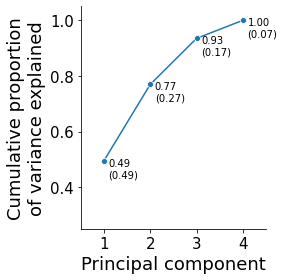

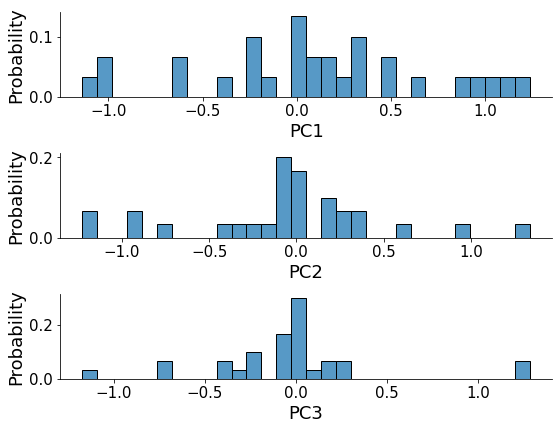

In [582]:
def pca_utility_params(data_path, save_path1='', save_path2='', select_best=True, latex_table=False, save_pca_to=''):
    df = pd.read_csv(data_path)
#     df = lut.rename_components(df)
    
    if select_best:
        df = df.loc[df.drank.eq(0), :]
    forms = sorted(list(df.form.unique()), key=len)
    if not select_best:
        df = df.loc[df.form.eq(forms[-1]), :]
    
    uparams = forms[-1].split(' + ')
    tparams = list(df.loc[:, 'tau':uparams[0]].columns)[1:3]
    indcols  = ['sid', 'form', 'group', 'aicc']
    df = df.filter(items=indcols+tparams+uparams)
    df = df.set_index(indcols)
    
    # Create standardization object
    udf = df.loc[:, uparams].fillna(0)
    scaler = StandardScaler()
    df_std = scaler.fit_transform(udf)
    df_std = udf.values
    
    # Do PCA on utility params
    pca = PCA()
    pca.fit(df_std)
    fig, ax = plt.subplots(ncols=1, num='pc_var_explained', figsize=[4, 4])
    evr = pca.explained_variance_ratio_
    sns.lineplot(x=range(1, evr.shape[0]+1), y=evr.cumsum(), markers=True, dashes=False, ax=ax, marker='o')
    for i, (ve, cve) in enumerate(zip(evr, evr.cumsum()), 1):
        ax.text(i+.1, cve-.06, f'{cve:.2f}\n({ve:.2f})')
    ax.set_xlabel('Principal component')
    ax.set_ylabel('Cumulative proportion\nof variance explained')
    ax.set_ylim(0.25, 1.05)
    ax.set_xlim(0.5, 4.5)
    scores = pca.transform(df_std)
    fig.tight_layout()
    if save_path1:
        print(f'Saving figure 1 to {save_path1}')
        fig.savefig(save_path1, dpi=300)
    
    # Select components and loadings
    ncomps = 3
    pca = PCA(n_components=ncomps)
    pca.fit(df_std)
    scores = pca.transform(df_std)
    pcomp_names = [f'PC{i}' for i in range(1, ncomps+1)]
    loadings = pd.DataFrame(pca.components_.T, columns=pcomp_names, index=udf.columns)
    print('Loadings:')
    correlations = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), 
        columns = pcomp_names, 
        index = udf.columns)
    if latex_table:
        print(correlations.reindex(correlations.abs().sort_values(by=pcomp_names, ascending=False).index).to_latex( float_format="%.2f"))
    else:
        display(correlations.reindex(correlations.abs().sort_values(by=pcomp_names, ascending=False).index))

    # Add principal components to the DF and save DF
    df = pd.concat([df.reset_index(), pd.DataFrame(scores)], axis=1)
    df.columns.values[-ncomps:] = pcomp_names
    if save_pca_to:
        print(f'Saving PCA data to {save_pca_to}')
        df.reset_index().to_csv(save_pca_to, index=False)
    
    bdata_path = '../data/behavior_data.csv'
    best_df = lut.filter_learners(df, bdata_path, n=30, by='final_rPC', which='top') # get top learners
    fig, ax = plt.subplots(nrows=ncomps, num='pc_distributions', figsize=[8, 6])
    for i, pc in enumerate(pcomp_names):
        sns.histplot(x=pc, data=best_df, bins=30, ax=ax[i], stat='probability')
    fig.tight_layout()
    if save_path2:
        print(f'Saving figure 2 to {save_path2}')
        fig.savefig(save_path2, dpi=300)

    
    
pca_utility_params(
    data_path = '../data/aic_stats_app4.csv',
    
    # If True, the best fitting model per subject is selected, else the full model will be selected
    select_best = True,
    
#     save_path1 = '../figures/pca_plot.png',
#     save_path2 = '../figures/pc_distributions.png',
    
#     latex_table = True,
#     save_pca_to = '../data/pca3_data_unstand.csv',
)

## Principal components predict behavior

### Learning

0

group activity    n  nfree  alloc     ipc15     fpc15     pcall  fscore  \
sid                                                                            
0        0       A1   15      0  0.000  0.933333  0.933333  0.933333      13   
0        0       A2   31     16  0.064  0.733333  0.933333  0.806452      19   
0        0       A3  193    178  0.712  0.200000  1.000000  0.818653     123   
0        0       A4   71     56  0.224  0.800000  0.266667  0.535211       5   
1        0       A1   89     74  0.296  0.666667  0.933333  0.887640      69   

     maxscore     speed  hirun      prog  
sid                                       
0          13  0.866667     14  0.000000  
0          19  0.612903     10  0.200000  
0         123  0.637306     33  0.800000  
0          13  0.565217      7 -0.533333  
1          69  0.775281     33  0.266667

final_rPC  delta_rPC
sid                      
0     0.966667   0.466667
1     0.788889   0.066667
2     0.488889  -0.022222
3     0.955556   0.122222
4     0.733333   0.144444

PC1:
final_rPC: r = 0.036, p = 0.655  
delta_rPC: r = 0.162, p = 0.041  *
PC2:
final_rPC: r = -0.204, p = 0.010  **
delta_rPC: r = -0.158, p = 0.047  *
Saving figure to ../figures/pc_corrs_learning.png


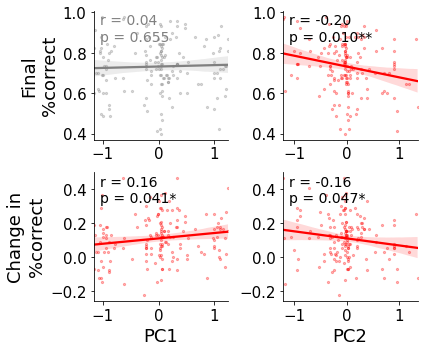

In [944]:
def behavioral_correlations_learning(data_path, behavior_data_path, save_path=''):
    bdf = pd.read_csv(behavior_data_path).set_index(['sid'])
    bdf['prog'] = bdf.fpc15 - bdf.ipc15
    bdf_ = bdf.loc[bdf.activity!='A4', :]
    gbdf = bdf.groupby('sid')
    gbdf_ = bdf_.groupby('sid')
    display(bdf.maxscore.values.min())
    display(bdf.head())
    
    df = gbdf[['n']].apply(lambda x: np.std(x))
    
    weighted_mean = lambda x: np.sum(x.values.squeeze()*(np.array([1,2,3])/6))
    flat_mean = lambda x: np.mean(x.values.squeeze())
    
    func = weighted_mean

    df.columns = ['alloc_bias']
    df['final_rPC'] = gbdf_[['fpc15']].apply(func)
    df['delta_rPC'] = gbdf_[['fpc15']].apply(func) - gbdf_[['ipc15']].apply(func)
#     df['PC'] = gbdf_[['pcall']].apply(func)
    df = df.drop(columns=('alloc_bias'))
    
    ylabs = {}
#     ylabs['alloc_bias'] = 'Allocation\nbias'
    ylabs['final_rPC'] = 'Final\n%correct'
    ylabs['delta_rPC'] = 'Change in\n%correct'
#     ylabs['PC'] = 'Overall\n%correct'
    
    display(df.head())
    
    rows = list(df.columns)
    cols = ['PC1','PC2']#,'PC3']
    df = pd.read_csv(data_path).merge(df, on='sid')
    
    fig, ax = lut.gen_regplots(
        df = df,
        figname = 'pc_corrs_learning',
        cols = cols, 
        rows = rows, 
        ylabels = ylabs
    )
    
    fig.tight_layout()
    if save_path:
        print(f'Saving figure to {save_path}')
        fig.savefig(save_path, dpi=300)

    
behavioral_correlations_learning(
    data_path = '../data/pca3_data_unstand.csv',
    behavior_data_path = '../data/behavior_data.csv',
    save_path = '../figures/pc_corrs_learning.png'
)

### Choices

activity     A1     A2     A3     A4
sid                                 
0         0.000  0.064  0.712  0.224
1         0.296  0.116  0.388  0.200
2         0.472  0.132  0.000  0.396
3         0.180  0.076  0.336  0.408
4         0.504  0.016  0.320  0.160

PC1:
A1: r = -0.077, p = 0.332  
A2: r = -0.164, p = 0.038  *
A3: r = 0.083, p = 0.300  
A4: r = 0.184, p = 0.020  *
PC2:
A1: r = 0.209, p = 0.008  **
A2: r = 0.025, p = 0.756  
A3: r = -0.163, p = 0.040  *
A4: r = -0.141, p = 0.075  
Saving figure to ../figures/pc_corrs_choices.png


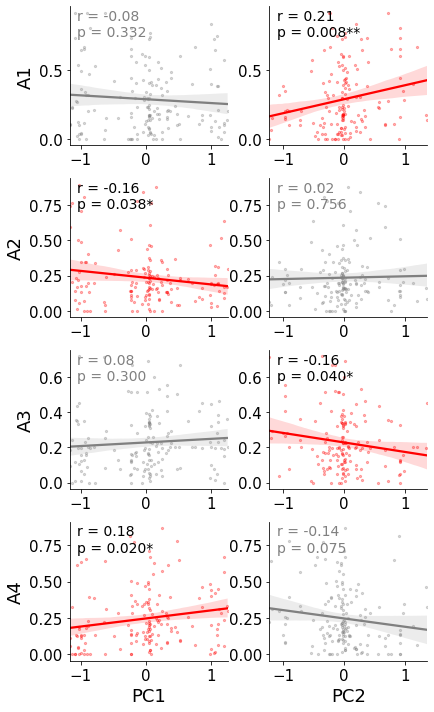

In [408]:
def behavioral_correlations_choices(data_path, behavior_data_path, save_path=''):
    df = pd.read_csv(behavior_data_path).filter(items=['sid','activity','alloc'])
    df = df.pivot(index='sid', columns='activity', values='alloc')
    display(df.head())
    
#     df['A3vsA4'] = df.A3 - df.A4
    rows = list(df.columns)
    cols = ['PC1', 'PC2']
    df = pd.read_csv(data_path).merge(df, on='sid')
    
    fig, ax = lut.gen_regplots(
        df = df,
        figname = 'pc_corrs_choices',
        cols = cols, 
        rows = rows, 
    )
    
    fig.tight_layout()
    if save_path:
        print(f'Saving figure to {save_path}')
        fig.savefig(save_path, dpi=300)

behavioral_correlations_choices(
    data_path = '../data/pca_data_unstand.csv',
    behavior_data_path = '../data/behavior_data.csv',
    save_path = '../figures/pc_corrs_choices.png'
)

# Temporal-scaling coeffcients

Clipping 121 cases with numberically unstable coefficients to 6.160657056849094e-11
(133, 12)


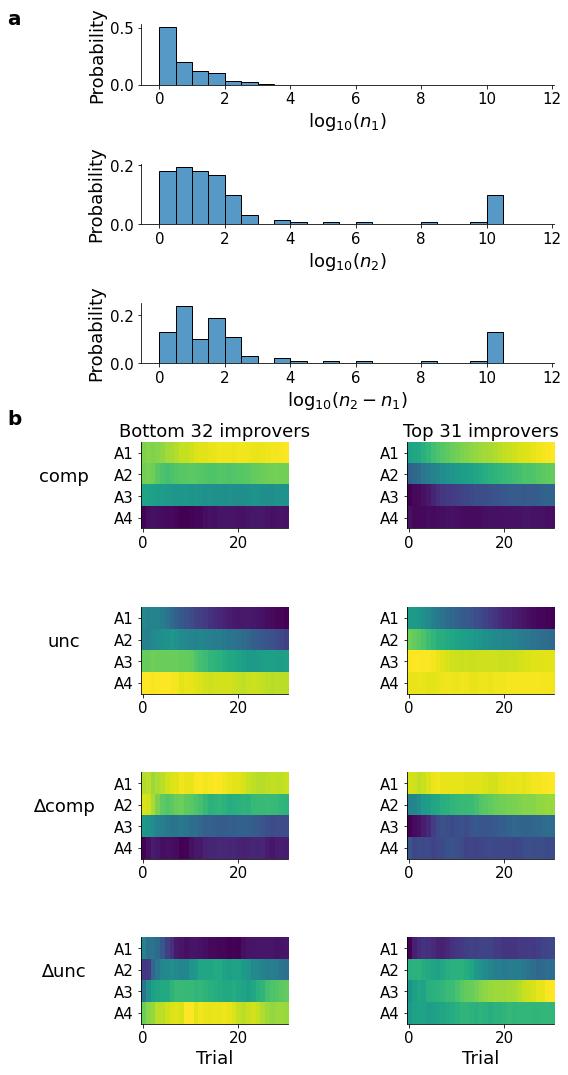

In [429]:
def fit_of_temp_params(ax, data_path, handle_outliers='clip', save_path=''):
    assert handle_outliers == 'clip' or handle_outliers == 'remove'
    
    df = pd.read_csv(data_path)
    df = df.loc[df.drank.eq(0), :]
    if handle_outliers == 'remove':
        to_incude = df.step*df.scale > 0
        print(f'Removeing {np.sum(to_incude)} cases with numberically unstable coefficients')
        df = df.loc[to_incude, :]
    
    df = df.dropna(subset=['scale'])    
    df = df.rename(columns={'step': 'alpha'})

    df['n1'] = 1/df.loc[:, 'alpha']
    df['alphaC'] = df.loc[:, 'alpha'] * df.loc[:, 'scale']
    if handle_outliers == 'clip':
        mask = df.alphaC != 0
        min_stable = df.loc[df.alphaC != 0, 'alphaC'].min()
        print(f'Clipping {np.sum(mask)} cases with numberically unstable coefficients to {min_stable}')
        df.loc[df.alphaC.eq(0), 'alphaC'] = min_stable
        
    df['n2'] = 1/df.alphaC
    df['logn1'] = np.log10(df.loc[:, 'n1'])
    df['logn2'] = np.log10(df.loc[:, 'n2'])
    df['ndiff'] = np.log10(df.n2 - df.n1)
    
    sns.histplot(x=df.logn1, bins=np.arange(0, 12, .5), stat='probability', ax=ax[0])
    ax[0].set_xlabel(r'$\log_{10}(n_1)$')
    
    sns.histplot(x=df.logn2, bins=np.arange(0, 12, .5), stat='probability', ax=ax[1])
    ax[1].set_xlabel(r'$\log_{10}(n_2)$')
    
    sns.histplot(x=df.ndiff, bins=np.arange(0, 12, .5), stat='probability', ax=ax[2])
    ax[2].set_xlabel(r'$\log_{10}(n_2 - n_1)$')


def coefs_and_features(ax, pca_data_path, raw_data_path, criterion, n):    
    df1 = pd.read_csv(pca_data_path)
    df1 = df1.dropna(subset=['scale']).set_index('sid')
    print(df1.shape)
    df2 = pd.read_csv(raw_data_path).filter(items=['sid','group','trial','activity','correct'])
    df2 = df2.loc[df2.trial<=250+60, :]
    
    bdata_path = '../data/behavior_data.csv'
    sids_top = lut.filter_learners(df1, bdata_path, n=n, by=criterion, which='top') # get top 20 improvers
    sids_bot = lut.filter_learners(df1, bdata_path, n=n, by=criterion, which='bottom') # get bottom 20 improvers
    
    labels = ['Bottom {} improvers'.format, 'Top {} improvers'.format]
    distrs, sizes = [[], []], []
    for half, sids in enumerate([sids_bot, sids_top]):
        outdict = {
            'comp' : [[] for i in '1234'],
            'unc'  : [[] for i in '1234'],
            '∆comp': [[] for i in '1234'],
            '∆unc' : [[] for i in '1234'],
        }
        for i, sdf in sids.groupby('sid'):
            head = sdf.head(1)
            alpha = head.step.values[0]
            c = head.scale.values[0]
            if alpha*c == 0:
                continue
            distrs[half].append(np.log10(1/(alpha*c) - 1/alpha))
            for j, act_ind in enumerate('1234'):
                x = df2.loc[df2.sid.eq(i) & df2.activity.eq(f'A{act_ind}'), 'correct'].values.astype(int)
                short = ewmv(x, alpha, return_keys=['mean', 'var'])
                long = ewmv(x, alpha*c, return_keys=['mean', 'var'])

                mean = short['mean']
                var = short['var']
                dmean = short['mean'] - long['mean']
                dvar = short['var'] - long['var']
                outdict['comp'][j].append(mean)
                outdict['unc'][j].append(var)
                outdict['∆comp'][j].append(dmean)
                outdict['∆unc'][j].append(dvar)
        outdict2, outdict3 = {}, {}
        for k, v in outdict.items():
            outdict2[k] = []
            outdict3[k] = []
            for i, l in enumerate(v):
                vec = lut.boolean_indexing(l)
                outdict2[k].append(
                    np.nanmean(vec, axis=0)
                )
#                 print(k, i, (1-np.isnan(vec).sum(0)/vec.shape[0])[45])
                outdict3[k].append(
                    stats.sem(vec, nan_policy='omit', axis=0)
                )
        del outdict

        lim, step = 45, 1
        for i, (k, v) in enumerate(outdict2.items()):
            inds = np.arange(15, lim+1, step)
            y = np.stack([j[:lim] for j in v], axis=0)
            y = np.cumsum(y, axis=1)[:,14::step] /inds[np.newaxis, :]
            yrr = np.stack([j[:lim] for j in outdict3[k]], axis=0)
            yrr = np.cumsum(yrr, axis=1)[:,14::step] /inds[np.newaxis, :]
            ax[i, half].imshow(y, aspect='auto')
            ax[i, half].set_yticks([0,1,2,3])
            ax[i, half].set_yticklabels(['A1','A2','A3','A4'])
            ax[i, half].set_ylabel(k, rotation=0, labelpad=50)
            if half:
                ax[i, half].set_ylabel('')
            
        ax[0, half].set_title(labels[half](len(distrs[half])))
        ax[-1, half].set_xlabel('Trial')


def make_fig4(figname, save_path=''):
    fig = plt.figure(figname, figsize=[8, 15], facecolor='w')
    gs = fig.add_gridspec(ncols=3, nrows=7, 
                          width_ratios=[.1, 1, 1],
                          height_ratios=[.7, .7, .7, 1, 1, 1, 1])
   
    # Subplot (a)
    lut.add_subplot_label(x=0, y=1., label='a', size=20, ax=fig.add_subplot(gs[0, 0]))
    axes = np.array([fig.add_subplot(gs[i, 1:]) for i in [0, 1, 2]])
    fit_of_temp_params(
        ax = axes,
        data_path = '../data/aic_stats_app4.csv',
        handle_outliers = 'clip', # How to handle extreme cases (clip or remove)
    )
   
    # Subplot (b)
    lut.add_subplot_label(x=0, y=1.2, label='b', size=20, ax=fig.add_subplot(gs[3, 0]))
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in [1, 2]] for i in range(3, 7)])
    coefs_and_features(
        ax = axes,
        pca_data_path = '../data/pca_data_unstand.csv', 
        raw_data_path = '../data/combined_main.csv', 
        criterion = 'delta_rPC',
        n = 35,
    )

    # Save figure
    fig.tight_layout()
#     fig.subplots_adjust(wspace=.2)
#     if save_path:
#         print(f'Saving figure as {save_path}')
#         fig.savefig(fname=save_path, dpi=300)

        
make_fig4(
    figname = 'figure4',
#     save_path = '../figures/temp_params.png',
)

# Fitted time windows vs fixed time windows

Clipping 147 cases with numberically unstable coefficients to 6.160657056849094e-11


(30, 23)

(133, 12)
(30, 13)
Saving figure as ../figures/fixed_vs_fitted_comps.png


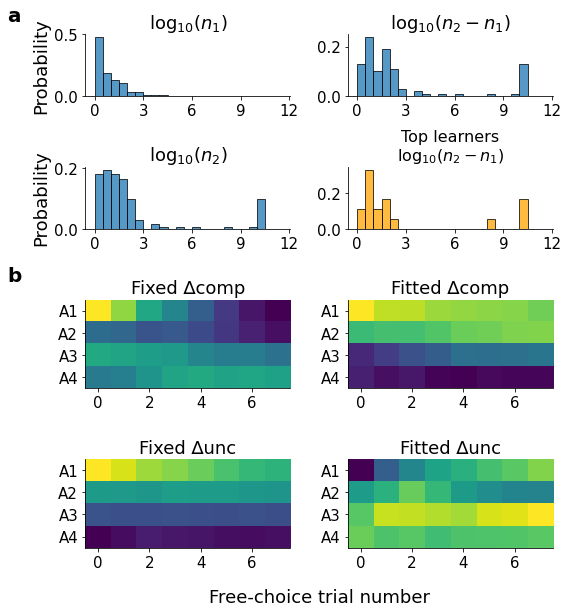

In [953]:
def fit_of_temp_params(axes, data_path, n, criterion, handle_outliers='clip', save_path=''):
    assert handle_outliers == 'clip' or handle_outliers == 'remove'
    
    df = pd.read_csv(data_path)
    df = df.loc[df.drank.eq(0), :]
    if handle_outliers == 'remove':
        to_incude = df.step*df.scale > 0
        print(f'Removeing {np.sum(to_incude)} cases with numberically unstable coefficients')
        df = df.loc[to_incude, :]
    
#     df = df.dropna(subset=['scale'])
    df = df.rename(columns={'step': 'alpha'})

    df['n1'] = 1/df.loc[:, 'alpha']
    df['alphaC'] = df.loc[:, 'alpha'] * df.loc[:, 'scale']
    if handle_outliers == 'clip':
        mask = df.alphaC != 0
        min_stable = df.loc[df.alphaC != 0, 'alphaC'].min()
        print(f'Clipping {np.sum(mask)} cases with numberically unstable coefficients to {min_stable}')
        df.loc[df.alphaC.eq(0), 'alphaC'] = min_stable
        
    df['n2'] = 1/df.alphaC
    df['logn1'] = np.log10(df.loc[:, 'n1'])
    df['logn2'] = np.log10(df.loc[:, 'n2'])
    df['ndiff'] = np.log10(df.n2 - df.n1)
    bins = np.arange(0, 12, .5)
    ax = axes[0]
    sns.histplot(x=df.logn1, bins=bins, stat='probability', ax=ax)
    ax.set_title(r'$\log_{10}(n_1)$', fontsize=18)
    ax.set_xlabel('')
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    
    ax = axes[1]
    sns.histplot(x=df.logn2, bins=bins, stat='probability', ax=ax)
    ax.set_title(r'$\log_{10}(n_2)$', fontsize=18)
    ax.set_xlabel('')
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    
    ax = axes[2]
    sns.histplot(x=df.ndiff, bins=bins, stat='probability', ax=ax)
    ax.set_title(r'$\log_{10}(n_2 - n_1)$', fontsize=18)
    ax.set_xlabel('')
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_ylabel('')
    
    bdata_path = '../data/behavior_data.csv'
    best_df = lut.filter_learners(df, bdata_path, n=n, by=criterion, which='top') # get top learners
    ax = axes[3]
    display(best_df.shape)
    sns.histplot(x=best_df.ndiff, bins=bins, stat='probability', ax=ax, color='orange')
    ax.set_title('Top learners\n'+r'$\log_{10}(n_2 - n_1)$', fontsize=16)
    ax.set_xlabel('')
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_ylabel('')


def coefs_and_features(ax, pca_data_path, raw_data_path, criterion, n):    
    df1 = pd.read_csv(pca_data_path)
    df1 = df1.dropna(subset=['scale']).set_index('sid')
    print(df1.shape)
    df2 = pd.read_csv(raw_data_path).filter(items=['sid','group','trial','activity','correct'])
    df2 = df2.loc[df2.trial<=250+60, :]
    
    bdata_path = '../data/behavior_data.csv'
    sids_top = lut.filter_learners(df1.reset_index(), bdata_path, n=n, by=criterion, which='top') # get top learners
    
    outdict = {
#         'Fitted comp' : [[] for i in '1234'],
#         'Fitted unc'  : [[] for i in '1234'],
        'Fitted ∆comp': [[] for i in '1234'],
        'Fitted ∆unc' : [[] for i in '1234'],
        
#         'Fixed comp': [[] for i in '1234'],
#         'Fixed unc': [[] for i in '1234'],
        'Fixed ∆comp': [[] for i in '1234'],
        'Fixed ∆unc': [[] for i in '1234'],
    }
    print(sids_top.shape)
    for i, sdf in sids_top.groupby('sid'):
        head = sdf.head(1)
        alpha = head.step.values[0]
        c = head.scale.values[0]
        if alpha*c == 0:
            continue
        for j, act_ind in enumerate('1234'):
            x = df2.loc[df2.sid.eq(i) & df2.activity.eq(f'A{act_ind}'), 'correct'].values.astype(int)
            short = ewmv(x, alpha, return_keys=['mean', 'var'])
            long = ewmv(x, alpha*c, return_keys=['mean', 'var'])
            
            mean = short['mean']
            var = short['var']
            dmean = short['mean'] - long['mean']
            dvar = short['var'] - long['var']
            
            fmean = lut.get_fmean(x)
            fdmean = lut.get_fdmean(x)
            fvar = lut.get_fvar(x)
            fdvar = lut.get_fdvar(x)
            
#             outdict['Fitted comp'][j].append(mean)
#             outdict['Fitted unc'][j].append(var)
            outdict['Fitted ∆comp'][j].append(dmean)
            outdict['Fitted ∆unc'][j].append(dvar)
             
#             outdict['Fixed comp'][j].append(fmean)
#             outdict['Fixed unc'][j].append(fvar)
            outdict['Fixed ∆comp'][j].append(fdmean)
            outdict['Fixed ∆unc'][j].append(fdvar)
    outdict2, outdict3 = {}, {}
    for k, v in outdict.items():
        outdict2[k] = []
        outdict3[k] = []
        for i, l in enumerate(v):
            vec = lut.boolean_indexing(l)
            outdict2[k].append(
                np.nanmean(vec, axis=0)
            )
    del outdict
    
    lim, step = 50, 5
    d1 = {k:v for (k,v) in outdict2.items() if 'Fixed' in k}
    d2 = {k:v for (k,v) in outdict2.items() if 'Fitted' in k}
    for j, d in enumerate([d1, d2]):
        for i, (k, v) in enumerate(d.items()):
            inds = np.arange(15, lim+1, step)
            y = np.stack([j[:lim] for j in v], axis=0)
            y = np.cumsum(y, axis=1)[:,14::step] /inds[np.newaxis, :]
            ax[i, j].imshow(y, aspect='auto')
            ax[i, j].set_yticks([0,1,2,3])
            ax[i, j].set_yticklabels(['A1','A2','A3','A4'])
            ax[i, j].set_title(k, fontsize=18)


def make_fig4(figname, n, save_path=''):
    fig = plt.figure(figname, figsize=[8, 9], facecolor='w')
    gs = fig.add_gridspec(ncols=3, nrows=4, 
                          width_ratios=[.1, 1, 1],
                          height_ratios=[.7, .7, 1, 1])
    gax = lut.ghost(fig.add_subplot(gs[3:, 1:], facecolor=None))
    gax.set_xlabel('Free-choice trial number', labelpad=40)
   
    # Subplot (a)
    lut.add_subplot_label(x=0, y=1.2, label='a', size=20, ax=fig.add_subplot(gs[0, 0]))
    axes = np.array([fig.add_subplot(gs[i, 1]) for i in [0, 1]] + \
                    [fig.add_subplot(gs[i, 2]) for i in [0, 1]])
    fit_of_temp_params(
        axes = axes,
        data_path = '../data/aic_stats_app4.csv',
        handle_outliers = 'clip', # How to handle extreme cases (clip or remove)
        criterion = 'final_rPC',
        n = n
    )

    # Subplot (b)
    lut.add_subplot_label(x=0, y=1.2, label='b', size=20, ax=fig.add_subplot(gs[2, 0]))
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in [1, 2]] for i in range(2, 4)])
    coefs_and_features(
        ax = axes,
        pca_data_path = '../data/pca_data_unstand.csv', 
        raw_data_path = '../data/combined_main.csv', 
        criterion = 'final_rPC',
        n = n,
    )

    # Save figure
    fig.tight_layout()
    fig.subplots_adjust(wspace=.4)
    if save_path:
        print(f'Saving figure as {save_path}')
        fig.savefig(fname=save_path, dpi=300)

        
make_fig4(
    figname = 'figure4',
    n = 30,
    save_path = '../figures/fixed_vs_fitted_comps.png'
)